## Data prepare

In [1]:
import os.path as osp
import numpy as np
from tqdm import tqdm_notebook, tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
%matplotlib inline
import skimage

In [2]:
def numpy_read(filename):
    if filename is None:
        return None

    filedir, basename = osp.split(filename)
    basename, _ext = osp.splitext(basename)

    parts = basename.split('_')
    assert(len(parts) >= 3)
    dtype, shape = parts[-2], parts[-1]
    dtype = np.dtype(dtype)
    shape = tuple(map(int, shape.split('x')))
    return np.memmap(
        filename,
        mode='readonly',
        shape=shape,
        dtype=dtype)


In [3]:
letters_inp = numpy_read('letters_inp_float32_46632x16x16x1.raw')
letters_out = numpy_read('letters_out_float32_46632x35.raw')
print(letters_out.sum(axis=0))

[ 1943.  1943.  1943.  1943.  1943.  1943.  1943.  1943.  1943.  1943.
  1943.  1943.  1943.  1943.  1943.  1943.  1943.  1943.  1943.  1943.
  1943.  1943.  1943.  1943.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.]


In [4]:
letters_inp = np.array(letters_inp)
letters_out = np.array(letters_out)

In [5]:
def big_figure(imgs, hc, wc, shift=2):
    assert(len(imgs) == hc*wc)
    
    # or vice versa
    h = len(imgs[0])
    w = len(imgs[0][0])
    
    
    H = hc * h + shift * (hc - 1)
    W = wc * w + shift * (wc - 1)
    
    pic = np.ndarray([H, W]) * 0.  
    for i in range(hc):
        for j in range(wc):
            sx = (h + shift) * i
            sy = (w + shift) * j
            pic[sx: sx + h, sy: sy + w] = imgs[i*wc + j][:,:,0]
            
    return pic

def to_index(one_hot):
    return sum(i*x for (i,x) in enumerate(one_hot))

def to_one_hot(index):
    out = np.zeros([len(letters_out[0])])
    out[int(index)] = 1
    return out

### Lets make some noise

In [6]:
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug import parameters as iap

In [7]:
def show_pict( by_val_aug, by_val, num_example, num_elements_of_exm):
    pics = []
    for ind in (range(num_example)):
        if (by_val != False):
            pics += [by_val_aug[ind][i] if i !=0 else by_val[ind][1] for i in range(num_elements_of_exm)]
        else:
            pics += [by_val_aug[ind][i] for i in range(num_elements_of_exm)]

    pic = big_figure(pics, num_example, num_elements_of_exm)
    plt.figure(figsize=(8,8))
    plt.imshow(pic, cmap='gray')
    plt.show()

In [8]:
blur_mean = 0.4
blur_dev = 0.2
blur_min = 0.1
blur_max = 0.5

scale_mean = 1
scale_dev = 0.2
scale_min = 0.8
scale_max = 1.2

rotate_mean = 0
rotate_dev = 5
rotate_min = -10
rotate_max = 10

gamma_mean = 1
gamma_dev = 0.2
gamma_min = 0.8
gamma_max = 1.25

num_drops = 3

In [9]:
seq = iaa.Sequential([
    
    iaa.GaussianBlur(sigma = iap.Clip(iap.Normal(blur_mean, blur_dev),blur_min,blur_max)),
    
    iaa.Affine(
        scale={"x": iap.Clip(iap.Normal(scale_mean, scale_dev),scale_min,scale_max), 
               "y": iap.Clip(iap.Normal(scale_mean, scale_dev),scale_min,scale_max)},
        
        rotate=iap.Clip(iap.Normal(rotate_mean, rotate_dev),rotate_min,rotate_max))
    ], 
    random_order=True) # apply augmenters in random order

In [10]:
def gamm_corr(imges, mean=gamma_mean, dev=gamma_dev, min_val=gamma_min, max_val=gamma_max):
    res_images = []
    for img in imges:
        gamma = np.random.normal(mean, dev)
        if gamma<min_val:
            gamma=min_val
        if gamma>max_val:
            gamma=max_val
        res_images.append(skimage.exposure.adjust_gamma(img, gamma=gamma))
    return np.array(res_images)

In [11]:
def drop_img(images, num_drop):
    drop_shape_list = [(5,5), (4,5), (5,4)]
    
    res_images = []
    for img_ in images:
        img = img_.copy()
        for i in range(num_drop):
            drop_shape = random.choice(drop_shape_list)
            rand_h = random.choice(range(0, img.shape[0] - drop_shape[0]))
            rand_w = random.choice(range(0, img.shape[1] - drop_shape[1]))
            img[rand_h:rand_h+drop_shape[0], rand_w:rand_w+drop_shape[1]] = random.randint(10, 200)/255
        res_images.append(img)
    return np.array(res_images)

In [12]:
def batch_gen(X,y, batch_size, min_num_in_group, max_num_in_group):
    imges_index = list(range(len(X)))
    while True:
        
        num_in_group = random.randint(min_num_in_group, max_num_in_group)
        if batch_size>len(imges_index):
            imges_index = list(range(X.shape[0]))
            yield np.array([False]), np.array([False]), np.array([False])
            
        rand_indexes = random.sample(imges_index, batch_size)
        for k in rand_indexes:
            imges_index.remove(k)
        
        res_group = []
        for k in range(num_in_group):
            res_group.append(drop_img(gamm_corr(seq.augment_images(X[rand_indexes])), num_drop=num_drops))
        res_group = np.stack(res_group,axis=1)
        yield np.array(res_group), y[rand_indexes], X[rand_indexes]

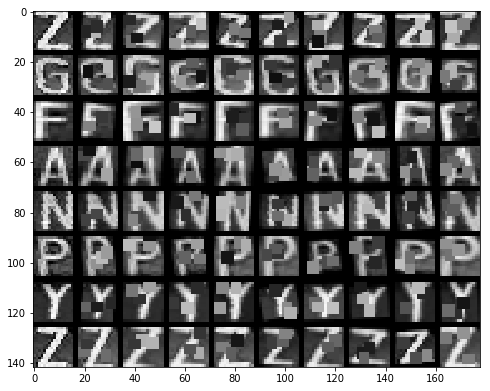

In [13]:
%matplotlib inline
num_example = 8
max_elements = 10
empty = np.zeros([16,16,1])
pics = []
gen = batch_gen(letters_inp,letters_out, 1, max_elements-1,max_elements-1)
# xx, yy, orig = next(gen)

for ind in (range(num_example)):
    imgs,yy,orig = next(gen)
    #print(imgs.shape)
    pics += [orig[0]]+ list(imgs[0]) + [empty] * (max_elements - len(imgs[0])-1) 

plt.figure(figsize=(8,8))
pic = big_figure(pics, num_example, max_elements)
plt.imshow(pic, cmap='gray')
plt.show()

## Experements with model

In [14]:
import pandas as pd
import matplotlib.pylab as plt

from keras.models import Sequential
from keras.layers.core import Activation, Flatten
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *
from keras.layers.embeddings import Embedding
from sklearn.metrics import accuracy_score
import keras
import keras.backend as K
from keras import metrics
from sklearn.model_selection import train_test_split
from keras.models import load_model
from sklearn.model_selection import cross_val_score

Using TensorFlow backend.


### Trainingn on single images

#### Trainingn on single images

In [15]:
def gen_for_test(X, Y, batch_size = 50):
    gen_test = batch_gen(X,Y, batch_size, 10, 10)
    while True:
        xx, yy, __ = next(gen_test)
        yy = np.repeat(yy,repeats=xx.shape[1], axis=0)
        xx = xx.reshape(xx.shape[0]*xx.shape[1], 16,16,1)
        yield xx, yy

In [16]:
# учитываем, что всего 24 класса
X_tr, X_te, Y_tr, Y_te = train_test_split(letters_inp,
                                          np.apply_along_axis(lambda x: x[:24],axis=1,arr=letters_out), 
                                          test_size=0.7,
                                          stratify = np.apply_along_axis(lambda x: x[:24],axis=1,arr=letters_out),
                                          random_state=42)

In [17]:
X_tr_add, X_all_test, Y_tr_add, Y_all_test = train_test_split(X_te,
                                                              Y_te, 
                                                              test_size=0.5,
                                                              stratify = np.argmax(Y_te, axis=1),
                                                              random_state=42)

In [18]:
dataset_10 = []
target_10 = []
for i in tqdm_notebook(range(24)):
    dataset_10.append(X_tr[np.where(np.argmax(Y_tr,axis=1) == i)[0][:10]])
    target_10.append(Y_tr[np.where(np.argmax(Y_tr,axis=1) == i)[0][:10]])
dataset_10 = np.array(dataset_10)
target_10 = np.array(target_10)

dataset_10 = dataset_10.reshape(240, 16, 16, 1)
target_10 = target_10.reshape(240,24)

dataset_10, _, target_10, _ = train_test_split(dataset_10,
                                          target_10, 
                                          test_size=0.,
                                          random_state=42)

In [19]:
dataset_10.shape

(240, 16, 16, 1)

(array([ 10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,
         10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,
         10.,  10.]),
 array([  0.        ,   0.95833333,   1.91666667,   2.875     ,
          3.83333333,   4.79166667,   5.75      ,   6.70833333,
          7.66666667,   8.625     ,   9.58333333,  10.54166667,
         11.5       ,  12.45833333,  13.41666667,  14.375     ,
         15.33333333,  16.29166667,  17.25      ,  18.20833333,
         19.16666667,  20.125     ,  21.08333333,  22.04166667,  23.        ]),
 <a list of 24 Patch objects>)

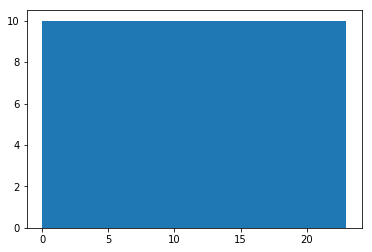

In [20]:
# распределение по классам
plt.hist(np.argmax(target_10, axis=1), bins=24)

In [21]:
gen_val = gen_for_test(X_all_test, Y_all_test, batch_size = 1000)
X_val, Y_val = next(gen_val)
print(X_val.shape)

(10000, 16, 16, 1)


In [22]:
batch_size = 64
group_size_min = 10
group_size_max = 10
num_classes = 24 # Y_tr.shape[1]
epochs = 20
img_rows, img_cols = 16, 16
input_shape = (img_rows, img_cols, 1)

In [23]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(32, (1, 1), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(16, (1, 1), activation='relu'))
model.add(Conv2D(16, (1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu', name='additional_out'))
#model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

filepath="./weights/Best_CNN_with_noise.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
hist = keras.callbacks.History()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [24]:
X_train = []
Y_train = []
gen_train = batch_gen(dataset_10,target_10, 5, group_size_min, group_size_max)

xx, yy,__ = next(gen_train)
X_train = xx.reshape(xx.shape[0]*xx.shape[1], 16,16,1)
Y_train = np.repeat(yy, repeats=xx.shape[1], axis=0)

while xx.any() != False:
    xx, yy,__ = next(gen_train)
    if (xx.any() == False):
        break
    X_train = np.vstack((X_train, xx.reshape(xx.shape[0]*xx.shape[1], 16,16,1)))
    Y_train = np.vstack((Y_train, np.repeat(yy,repeats=xx.shape[1], axis=0)))

In [25]:
X_train.shape

(2400, 16, 16, 1)

In [26]:
Y_train.shape

(2400, 24)

In [27]:
for i in np.unique(np.argmax(Y_train, axis=1)):
    print ("Class ", i, (np.argmax(Y_train, axis=1) == i).sum())

Class  0 100
Class  1 100
Class  2 100
Class  3 100
Class  4 100
Class  5 100
Class  6 100
Class  7 100
Class  8 100
Class  9 100
Class  10 100
Class  11 100
Class  12 100
Class  13 100
Class  14 100
Class  15 100
Class  16 100
Class  17 100
Class  18 100
Class  19 100
Class  20 100
Class  21 100
Class  22 100
Class  23 100


In [28]:
history = model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data = (X_val, Y_val),
          callbacks = [checkpoint])

Train on 2400 samples, validate on 10000 samples
Epoch 1/20
2400/2400 [==============================] - 3s 1ms/step - loss: 3.1620 - acc: 0.0596 - val_loss: 3.0809 - val_acc: 0.1299
Epoch 2/20
2400/2400 [==============================] - 2s 973us/step - loss: 2.6074 - acc: 0.2317 - val_loss: 2.4814 - val_acc: 0.2877
Epoch 3/20
2400/2400 [==============================] - 2s 940us/step - loss: 1.9097 - acc: 0.4446 - val_loss: 2.0747 - val_acc: 0.3981
Epoch 4/20
2400/2400 [==============================] - 3s 1ms/step - loss: 1.4740 - acc: 0.5571 - val_loss: 1.6925 - val_acc: 0.4733
Epoch 5/20
2400/2400 [==============================] - 3s 1ms/step - loss: 1.1868 - acc: 0.6258 - val_loss: 1.6154 - val_acc: 0.5263
Epoch 6/20
2400/2400 [==============================] - 3s 1ms/step - loss: 0.9583 - acc: 0.7046 - val_loss: 1.4311 - val_acc: 0.5845
Epoch 7/20
2400/2400 [==============================] - 3s 1ms/step - loss: 0.7521 - acc: 0.7575 - val_loss: 1.1027 - val_acc: 0.6651
Epoch 8/2

In [29]:
#model.load_weights(filepath)

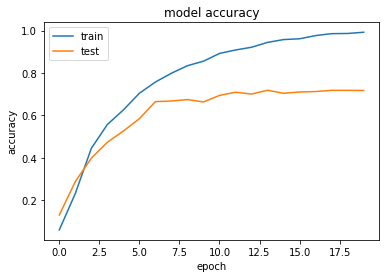

In [30]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

#### Testing on single images

In [31]:
gen_test = gen_for_test(X_all_test, Y_all_test)

In [32]:
score = model.evaluate_generator(gen_test, steps=int((X_all_test.shape[0])/50)-1)

In [33]:
print("Accuracy score: ", score[1])

Accuracy score:  0.721944615107


#### Testing Answer Averaging

In [34]:
def test_predict( X, Y, num_in_group, model = model):
    Y_pred = []
    Y_true = []
    gen_train = batch_gen(X,Y, 50, num_in_group, num_in_group)

    xx, yy,__ = next(gen_train)
    
    while xx.any() != False:
        for i in range(xx.shape[0]):
            Y_true.append(yy[i])
            Y_pred.append(model.predict(xx[i]).mean(axis=0))
            
        xx, yy,__ = next(gen_train)
        
    return np.array(Y_true), np.array(Y_pred)

In [35]:
y_true, y_pred = test_predict(X_all_test, Y_all_test, 10, model)

In [36]:
elements_in_group = list(range(0,21,3))

In [37]:
elements_in_group = list(range(0,21,3))
elements_in_group[0] = 1
results = []
for i in tqdm_notebook(elements_in_group):
    y_true, y_pred = test_predict(X_all_test, Y_all_test, i, model)
    results.append(accuracy_score([np.argmax(x) for x in y_true], [np.argmax(x) for x in y_pred]))
results = np.array(results)

In [38]:
y_true.shape

(16300, 24)

In [39]:
results

array([ 0.71920245,  0.85773006,  0.90785276,  0.92245399,  0.92907975,
        0.93208589,  0.93564417])

In [40]:
elements_in_group

[1, 3, 6, 9, 12, 15, 18]

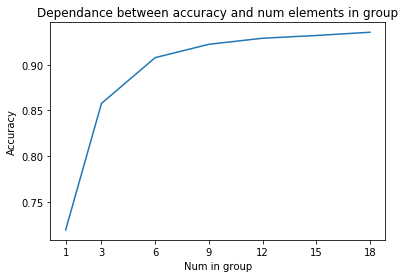

In [41]:
plt.plot(elements_in_group, results)
plt.xticks(elements_in_group, elements_in_group)
# plt.yticks(results, results)
plt.title("Dependance between accuracy and num elements in group")
plt.ylabel('Accuracy')
plt.xlabel('Num in group')

In [42]:
np.save('results',results)

### Training additional model

#### Generatge dataset for additional model

In [43]:
from keras.models import Model

In [44]:
layer_name = 'additional_out'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
#intermediate_output = intermediate_layer_model.predict(data)

In [45]:
def get_features(array):
    features = []
    features.append(array.min())
    features.append(array.max())
    features.append(array.std())
    features.append(array.mean())
    return np.array(features)

In [46]:
def get_add_dataset(X, Y, model, num_in_group = 5):
    X_add = []
    Y_add = []
    gen_train = batch_gen(X,Y, 50, num_in_group, num_in_group)


    xx, yy,__ = next(gen_train)
    while xx.any() != False:
        for i in range(xx.shape[0]):
            Y_add.append(yy[i])
            featured = np.array([get_features(x) for x in model.predict(xx[i]).T]).flatten()
            X_add.append(featured)

        xx, yy,__ = next(gen_train)
    return np.array(X_add), np.array(Y_add)

In [47]:
X_add, Y_add = get_add_dataset(X_tr_add, Y_tr_add, intermediate_layer_model)

In [48]:
X_add.shape

(16300, 512)

In [49]:
Y_add.shape

(16300, 24)

#### Extra models training

In [50]:
extra_model = Sequential()
extra_model.add(Dense(128, input_shape=(X_add.shape[1],)))
extra_model.add(Dropout(0.2))
extra_model.add(Dense(256))
extra_model.add(Dropout(0.3))
#model.add(Dropout(0.25))
#model.add(Dropout(0.5))
extra_model.add(Dense(num_classes, activation='softmax'))

hist = keras.callbacks.History()

extra_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [51]:
history = extra_model.fit(X_add, Y_add, 
                    batch_size=64,
                    epochs=100)

Epoch 1/100
16300/16300 [==============================] - 1s 61us/step - loss: 1.6879 - acc: 0.7087
Epoch 2/100
16300/16300 [==============================] - 1s 53us/step - loss: 0.4839 - acc: 0.8782
Epoch 3/100
16300/16300 [==============================] - 1s 53us/step - loss: 0.3725 - acc: 0.9068
Epoch 4/100
16300/16300 [==============================] - 1s 53us/step - loss: 0.3315 - acc: 0.9153
Epoch 5/100
16300/16300 [==============================] - 1s 54us/step - loss: 0.3000 - acc: 0.9257
Epoch 6/100
16300/16300 [==============================] - 1s 54us/step - loss: 0.2681 - acc: 0.9326
Epoch 7/100
16300/16300 [==============================] - 1s 54us/step - loss: 0.2359 - acc: 0.9349
Epoch 8/100
16300/16300 [==============================] - 1s 55us/step - loss: 0.2318 - acc: 0.9413
Epoch 9/100
16300/16300 [==============================] - 1s 55us/step - loss: 0.2216 - acc: 0.9410
Epoch 10/100
16300/16300 [==============================] - 1s 60us/step - loss: 0.2137 - a

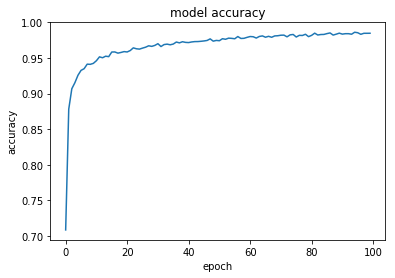

In [52]:
plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [53]:
#import xgboost
import lightgbm

lgb = lightgbm.LGBMClassifier()
lgb.fit(X_add, np.argmax(Y_add, axis=1))

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

In [54]:
cross_val_score(lgb, X_add, np.argmax(Y_add, axis=1), cv=2)

array([ 0.95057034,  0.94697435])

### Testing CNN + additional model

In [55]:
def print_score(name_additional, elements_in_group,results):
    print("Additional model - ", name_additional)
    for i,j in zip(elements_in_group, results):
        print("     Num elements in group: {}, score: {:.3f}".format(i, j))

In [56]:
def all_test_pred( X, Y, num_in_group, model, extra_model = extra_model):
    Y_pred = []
    Y_true = []
    gen_train = batch_gen(X,Y, 50, num_in_group, num_in_group)

    xx, yy,__ = next(gen_train)
    
    while xx.any() != False:
        for i in range(xx.shape[0]):
            Y_true.append(yy[i])
            #Y_pred.append(model.predict(xx[i]).mean(axis=0))
            featured_x = np.array([get_features(x) for x in model.predict(xx[i]).T]).flatten()
            Y_pred.append(extra_model.predict(featured_x.reshape(1, featured_x.shape[0])))
            
        xx, yy,__ = next(gen_train)
        
    return np.array(Y_true), np.array(Y_pred)

(array([ 204.,  207.,  209.,  199.,  207.,  222.,  217.,  212.,  203.,
         210.,  200.,  212.,  221.,  204.,  226.,  218.,  203.,  201.,
         211.,  215.,  208.,  194.,  188.,  209.]),
 array([  0.        ,   0.95833333,   1.91666667,   2.875     ,
          3.83333333,   4.79166667,   5.75      ,   6.70833333,
          7.66666667,   8.625     ,   9.58333333,  10.54166667,
         11.5       ,  12.45833333,  13.41666667,  14.375     ,
         15.33333333,  16.29166667,  17.25      ,  18.20833333,
         19.16666667,  20.125     ,  21.08333333,  22.04166667,  23.        ]),
 <a list of 24 Patch objects>)

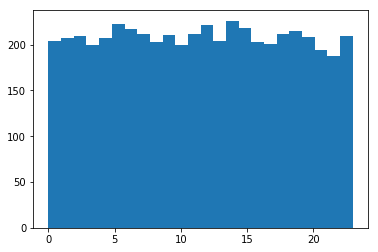

In [57]:
plt.hist(np.argmax(Y_all_test[:5000],axis=1), bins=24)

In [58]:
elements_in_group_all = list(range(0,21,3))
elements_in_group_all[0] = 1
results_all = []
for i in tqdm_notebook(elements_in_group_all):
    y_true, y_pred = all_test_pred(X_all_test[:5000], Y_all_test[:5000], num_in_group=i,model = intermediate_layer_model, extra_model=extra_model)
    results_all.append(accuracy_score([np.argmax(x) for x in y_true], [np.argmax(x) for x in y_pred]))
results_all = np.array(results_all)
#y_pred_dense = y_pred.copy()

In [59]:
elements_in_group_xgb = list(range(0,21,3))
elements_in_group_xgb[0] = 1
results_xgb = []
for i in tqdm_notebook(elements_in_group_xgb):
    y_true, y_pred = all_test_pred(X_all_test[:5000], Y_all_test[:5000], num_in_group=i,model = intermediate_layer_model, extra_model=lgb)
    results_xgb.append(accuracy_score([np.argmax(x) for x in y_true], y_pred))
results_xgb = np.array(results_xgb)
#y_pred_lgb = y_pred.copy()

NN
Extra model trained on the groups of 5


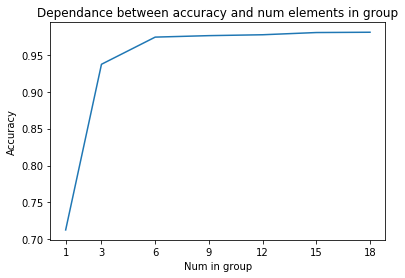

In [60]:
plt.plot(elements_in_group_all, results_all)
plt.xticks(elements_in_group_all, elements_in_group_all)
# plt.yticks(results, results)
plt.title("Dependance between accuracy and num elements in group")
plt.ylabel('Accuracy')
plt.xlabel('Num in group')
print("NN")
print("Extra model trained on the groups of 5")

XGB
Extra model trained on the groups of 5


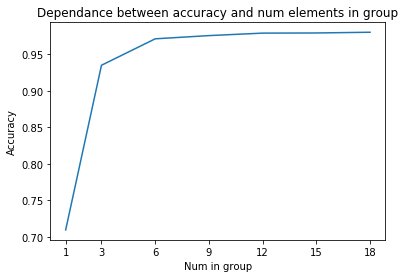

In [61]:
plt.plot(elements_in_group_xgb, results_xgb)
plt.xticks(elements_in_group_xgb, elements_in_group_xgb)
# plt.yticks(results, results)
plt.title("Dependance between accuracy and num elements in group")
plt.ylabel('Accuracy')
plt.xlabel('Num in group')
print("XGB")
print("Extra model trained on the groups of 5")

In [62]:
print_score('lgb', elements_in_group_xgb, results_xgb)
print_score('Dense', elements_in_group_all, results_all)
print_score('Mean', elements_in_group, results)

Additional model -  lgb
     Num elements in group: 1, score: 0.710
     Num elements in group: 3, score: 0.935
     Num elements in group: 6, score: 0.971
     Num elements in group: 9, score: 0.976
     Num elements in group: 12, score: 0.979
     Num elements in group: 15, score: 0.979
     Num elements in group: 18, score: 0.980
Additional model -  Dense
     Num elements in group: 1, score: 0.713
     Num elements in group: 3, score: 0.937
     Num elements in group: 6, score: 0.974
     Num elements in group: 9, score: 0.976
     Num elements in group: 12, score: 0.977
     Num elements in group: 15, score: 0.980
     Num elements in group: 18, score: 0.981
Additional model -  Mean
     Num elements in group: 1, score: 0.719
     Num elements in group: 3, score: 0.858
     Num elements in group: 6, score: 0.908
     Num elements in group: 9, score: 0.922
     Num elements in group: 12, score: 0.929
     Num elements in group: 15, score: 0.932
     Num elements in group: 18, score

In [63]:
results

array([ 0.71920245,  0.85773006,  0.90785276,  0.92245399,  0.92907975,
        0.93208589,  0.93564417])

In [64]:
results_all

array([ 0.7128,  0.9372,  0.974 ,  0.976 ,  0.9772,  0.9802,  0.9806])

In [65]:
results_xgb

array([ 0.7096,  0.935 ,  0.9712,  0.9756,  0.979 ,  0.9792,  0.9802])

In [66]:
elements_in_group

[1, 3, 6, 9, 12, 15, 18]

In [74]:
# old results
#print_score('lgb', elements_in_group_xgb, results_xgb)
print_score('Dense', elements_in_group_all, np.load('results_all.npy'))
print_score('Mean', elements_in_group, results)

Additional model -  Dense
     Num elements in group: 1, score: 0.712
     Num elements in group: 3, score: 0.883
     Num elements in group: 6, score: 0.940
     Num elements in group: 9, score: 0.953
     Num elements in group: 12, score: 0.958
     Num elements in group: 15, score: 0.958
     Num elements in group: 18, score: 0.959
Additional model -  Mean
     Num elements in group: 1, score: 0.719
     Num elements in group: 3, score: 0.858
     Num elements in group: 6, score: 0.908
     Num elements in group: 9, score: 0.922
     Num elements in group: 12, score: 0.929
     Num elements in group: 15, score: 0.932
     Num elements in group: 18, score: 0.936


------

### Result analysis

In [68]:
for i in np.unique(np.argmax(y_true, axis=1)):
    print ("Class ", i, (np.argmax(y_true, axis=1) == i).sum())

Class  0 204
Class  1 207
Class  2 209
Class  3 199
Class  4 207
Class  5 222
Class  6 217
Class  7 212
Class  8 203
Class  9 210
Class  10 200
Class  11 212
Class  12 221
Class  13 204
Class  14 226
Class  15 218
Class  16 203
Class  17 201
Class  18 211
Class  19 215
Class  20 208
Class  21 194
Class  22 188
Class  23 209


(array([ 204.,  207.,  209.,  199.,  207.,  222.,  217.,  212.,  203.,
         210.,  200.,  212.,  221.,  204.,  226.,  218.,  203.,  201.,
         211.,  215.,  208.,  194.,  188.,  209.]),
 array([  0.        ,   0.95833333,   1.91666667,   2.875     ,
          3.83333333,   4.79166667,   5.75      ,   6.70833333,
          7.66666667,   8.625     ,   9.58333333,  10.54166667,
         11.5       ,  12.45833333,  13.41666667,  14.375     ,
         15.33333333,  16.29166667,  17.25      ,  18.20833333,
         19.16666667,  20.125     ,  21.08333333,  22.04166667,  23.        ]),
 <a list of 24 Patch objects>)

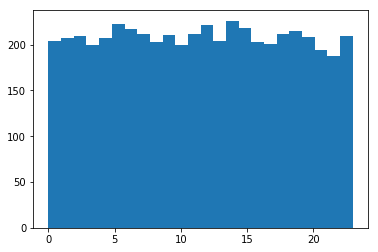

In [69]:
plt.hist(np.argmax(y_true, axis=1), bins=24)

3


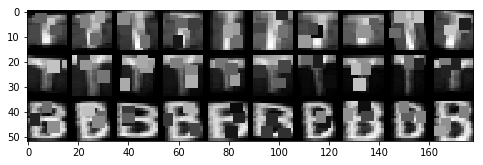

5


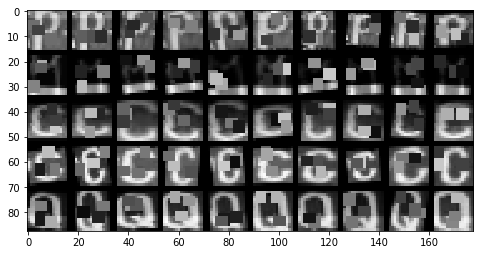

6


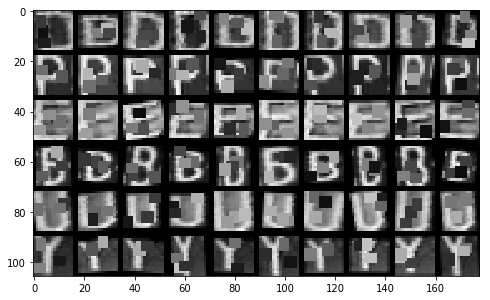

In [70]:
num_in_group = 10
gen_train = batch_gen(X_te,Y_te, 50, num_in_group, num_in_group)
where_wrong_index = []

xx, yy,__ = next(gen_train)
num_showed = 0
num_showed_max = 10

while xx.any() != False:
    where_wrong_index = []
    for i in range(xx.shape[0]):
        Y_true = np.argmax(yy[i])
        Y_pred = np.argmax(model.predict(xx[i]).mean(axis=0))
        if Y_true != Y_pred:
            where_wrong_index.append(i)
#         print("\tPreds", Y_true, Y_pred)
    
    if num_showed > num_showed_max:
        break
    print(len(where_wrong_index))
    if len(where_wrong_index) == 0:
        continue
        
    num_example = len(where_wrong_index)
    num_showed += num_example
    empty = np.zeros([16,16,1])
    pics = []
    for ind in where_wrong_index:
        imgs = xx[ind]
        pics += list(imgs) + [empty] * (num_in_group - len(imgs)) 
        
    plt.figure(figsize=(8,8))
    pic = big_figure(pics, len(where_wrong_index), num_in_group)
    plt.imshow(pic, cmap='gray')
    plt.show()
    
    xx, yy,__ = next(gen_train)

-------

In [71]:
# sore_on_val = []
# sore_on_train = []
# for ep in range(epochs):
#     print('Epoch #', ep)
#     gen = batch_gen(dataset_10,target_10, 1, group_size_min, group_size_max)
#     for batching in range(0, dataset_10.shape[0]-batch_size, batch_size):
#         #print('\tBatch #', batching/batch_size+1)
#         for i in range(batch_size):
#             X, Y, origin = next(gen)
#             model.train_on_batch(X[0], np.repeat(Y,repeats=X.shape[1], axis=0))
#     sore_on_val.append(model.evaluate(X_te[:8000], Y_te[:8000], verbose=0))
#     sore_on_train.append(model.evaluate(dataset_10, target_10, verbose=0))
#     print('    Train: Loss: {0:1.3f}, acc:{1:1.3f}'.format(sore_on_train[-1][0], sore_on_train[-1][1]))
#     print('    Validation: Loss: {0:1.3f}, acc:{1:1.3f}'.format(sore_on_val[-1][0], sore_on_val[-1][1]))

# sore_on_train = np.array(sore_on_train)
# sore_on_val = np.array(sore_on_val)

30 на класс

In [72]:
# plt.plot(list(range(epochs)),sore_on_val[:,1])
# plt.plot(list(range(epochs)),sore_on_train[:,1])

# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.xticks(list(range(epochs)), list(range(epochs)))
# plt.legend(['test','train'], loc='upper left')
# print ('Score on test: acc ', model.evaluate(X_te, Y_te, verbose=0)[1])
# plt.show()

------

* Validation
* Play with deskriptors ( different number of them )
* make something new